In [1]:
import numpy as np
from astropy.io import fits
from loguru import logger
from pathlib import Path

from surfh.Models import instru

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import ndimage

from sklearn.decomposition import NMF
from einops import rearrange
from surfh.Models import wavelength_mrs
from surfh.Simulation import simulation_data
from matplotlib.widgets import Slider


In [3]:
def plot_cube(cube, wavelength_cube):
    
    if cube.shape[0] != 4:
        idx = np.where(np.sum(cube, axis=(1,2)) != 0)[0]
        nzero_slice = slice(idx[0], idx[-1])
        print(nzero_slice)
        cube = cube[nzero_slice, ...]
        wavelength_cube = wavelength_cube[nzero_slice]

    # Initial lambda index
    initial_lambda = 0
    nLambda = cube.shape[0]

    # Create a figure and axis
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.1, bottom=0.25)  # Adjust the subplot to make space for the slider

    # Display the initial slice
    slice_plot = ax.imshow(cube[initial_lambda, :, :], cmap='viridis')
    ax.set_title(f'Lambda slice: {initial_lambda}')
    ax.plot(7,20,'.')
    ax.plot(37,10,'.')
    ax.plot(14,44,'.')
    ax.plot(40,31,'.')    
    # Add a colorbar
    cbar = plt.colorbar(slice_plot, ax=ax)

    # Create the slider axis and slider
    ax_slider = plt.axes([0.1, 0.1, 0.8, 0.05], facecolor='lightgoldenrodyellow')
    slider = Slider(ax_slider, 'Lambda', 0, nLambda - 1, valinit=initial_lambda, valstep=1)

    # Update function to be called when the slider is changed
    def update(val):
        lambda_index = int(slider.val)
        # Update the image data
        new_slice = cube[lambda_index, :, :]
        slice_plot.set_data(new_slice)
        
        # Update the color limits for the current slice
        slice_plot.set_clim(vmin=np.min(new_slice), vmax=np.max(new_slice))

        # Redraw the colorbar with the new limits
        cbar.update_normal(slice_plot)

        # Update the title to show the current lambda slice
        ax.set_title(f'Lambda slice: {wavelength_cube[lambda_index]}')
        
        # Redraw the figure canvas
        fig.canvas.draw_idle()

    # Attach the update function to the slider
    slider.on_changed(update)

    plt.show()

In [18]:
hdul = fits.open('/home/nmonnier/Data/JWST/Orion_bar/Fusion/ChannelCube_ch1-2-shortmediumlong_s3d.fits')
data_cube = hdul[1].data
raw_data_cube = hdul[1].data
hdr = hdul[1].header
wavel = np.array(hdul[5].data[0])[0,:,0]


coords = [(8,13), (8,38), (40,38), (40,13)]

from scipy.ndimage import rotate

angle = -20  # angle en degrés

# Créer un nouveau cube pour stocker les résultats
rotated_cube = np.empty_like(raw_data_cube)
raw_data_cube[np.isnan(raw_data_cube)] = 0
# Appliquer la rotation pour chaque tranche spectrale
for i in range(raw_data_cube.shape[0]):
    # Appliquer la rotation en 2D en gardant le centre de la tranche comme centre de rotation
    rotated_cube[i] = rotate(raw_data_cube[i], angle=angle, reshape=False, axes=(1, 0), order=3, mode='nearest')

masked_array = rotated_cube[:,13:38,8:40]


plt.figure()
plt.imshow(masked_array[100])
plt.title("Rotated cube")
plt.show()


masked_array_fitlered_data_cube = ndimage.median_filter(masked_array.copy(), size=15, axes=[0])

data = rearrange(data_cube, 'L I J -> (I J) L') # from spectro data
masked_array_fitlered_data = rearrange(masked_array_fitlered_data_cube, 'L I J -> (I J) L') # from spectro data
plt.figure()
plt.plot(wavel, np.mean(masked_array, axis=(1,2)))
plt.figure()
plt.plot(wavel, np.mean(masked_array_fitlered_data_cube, axis=(1,2)))



Using matplotlib backend: TkAgg


In [11]:
%matplotlib


plot_cube(raw_data_cube, wavel)
plot_cube(masked_array, wavel)



Using matplotlib backend: TkAgg
slice(0, 6314, None)
slice(0, 6314, None)


In [19]:
# Range of components to test
component_range = range(1, 12)  # Adjust based on how many tests you want to run
￼
# List to store the reconstruction errors
reconstruction_errors = []
mre_reconstruction_errors = []

# Compute NMF for different numbers of components and calculate the reconstruction errors
for n_components in component_range:
    nmf = NMF(n_components=n_components, init='random', random_state=42)
    W = nmf.fit_transform(masked_array_fitlered_data)  # W is the weight matrix
    H = nmf.components_          # H is the feature matrix (components)
    reconstructed = W @ H        # Reconstruct the original matrix
    error = np.linalg.norm(masked_array_fitlered_data - reconstructed)  # Frobenius norm
    mre_error = np.mean(np.divide((masked_array_fitlered_data-reconstructed), masked_array_fitlered_data, out=np.zeros_like(masked_array_fitlered_data), where=masked_array_fitlered_data!=0))

    reconstruction_errors.append(error)
    mre_reconstruction_errors.append(np.abs(mre_error))

# Plotting the reconstruction errors
plt.figure(figsize=(10, 5))
plt.plot(component_range, reconstruction_errors, marker='o')
plt.title('Reconstruction Errors by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.grid(True)

# Plotting the reconstruction errors
plt.figure(figsize=(10, 5))
plt.plot(component_range, mre_reconstruction_errors, marker='o')
plt.title('Mean relative error Reconstruction Errors by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('MRE')
plt.grid(True)

/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number 

In [27]:
from sklearn.decomposition import NMF

# Initialize NMF with the desired number of components
nmf = NMF(n_components=6, init='random', random_state=0, max_iter=1000)

# Fit NMF model to your data
nmf.fit(masked_array_fitlered_data)

# Extract the components (eigenvectors)
components = nmf.components_

plt.figure()
for i in range(components.shape[0]):
    plt.plot(wavel, components[i], label=i)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Wavelength", fontsize=22)
plt.legend()
 



plt.figure()
scale_f = np.max(np.mean(masked_array_fitlered_data_cube, axis=(1,2)))/np.max(np.mean(components, axis=0))
#scale_f = np.mean(fitlered_data_cube, axis=(1,2))[-1]/np.mean(components, axis=0)[-1]

plt.plot(wavel, np.mean(components, axis=0)*scale_f, label='templates')
plt.plot(wavel, np.mean(masked_array_fitlered_data_cube, axis=(1,2)), label='real data')
plt.legend()


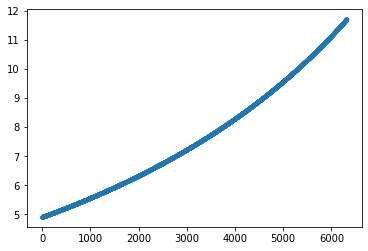

In [19]:
plt.plot(wavel, '.')

[40 44 48 52 56 60 64 68 72 76]
(6, 1578)


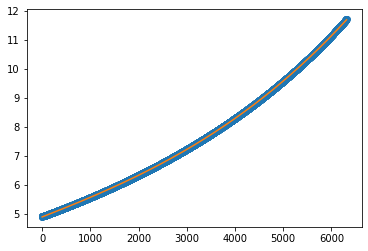

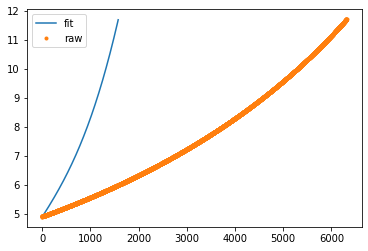

In [6]:
from scipy.optimize import curve_fit

def second_order_function(x, A, B, C):
    return A + B*x**2 + C*x

def third_order_function(x, A, B, C, D):
    return A + D*x**3 + B*x**2 + C*x


def exponential(x, A, B, C):
    return A + B*np.exp(C*x)

def cos_func(x, D, E, A):
    y = A + D*np.cos(E*x)
    return y


xdata = np.arange(len(wavel))
ydata = wavel
parameters, covariance = curve_fit(third_order_function, xdata, ydata)
fit_D = parameters[0]
fit_G = parameters[1]
fit_1 = parameters[2]
fit_2 = parameters[3]


fit_cosine = third_order_function(xdata, fit_D, fit_G, fit_1, fit_2)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_cosine, '-', label='fit')


def downsample_interpolation(vector, target_size):
    x_old = np.linspace(0, 1, len(vector))
    x_new = np.linspace(0, 1, target_size)
    return np.interp(x_new, x_old, vector)

#wavel_axis = np.linspace(wavel.min(), wavel.max(), len(wavel)-1)

test = downsample_interpolation(np.arange(len(wavel)), len(wavel)//4)
print((test[10:20].astype(int)))
subsampled_interpn = np.zeros((components.shape[0], len(test)))

for i in range(components.shape[0]):
    subsampled_interpn[i] = third_order_function(test.astype(int), fit_D, fit_G, fit_1, fit_2)

wavel_axis = third_order_function(test.astype(int), fit_D, fit_G, fit_1, fit_2)
plt.figure()
plt.plot(wavel_axis, '-', label='fit')
plt.plot(wavel, '.', label='raw')
plt.legend()

subsampled_interpn = np.zeros((components.shape[0], len(test)))

for i in range(components.shape[0]):
    subsampled_interpn[i] = np.interp(wavel_axis, wavel, components[i])


print(subsampled_interpn.shape)

In [14]:

# for i in range(components.shape[0]):
#     subsampled_interpn[i] = downsample_interpolation(components[i], len(wavel_axis))



[20 22 24 26 28 30 32 34 36 38]


In [12]:
def reduce_vector_to_shape(vector, target_shape):
    """
    Reduce a vector by randomly removing elements to reach the specified target shape.\n",
    \n",
    Parameters:\n",
    vector (np.ndarray): The input vector to reduce.\n",
    target_shape (int): The target length of the vector.\n",
    \n",
    Returns:\n",
    np.ndarray: The reduced vector.\n",
    """
    original_shape = vector.shape[0]
 
    first_subsampled_factor = original_shape//target_shape
    tmp_vector = vector[::first_subsampled_factor]
    tmp_shape = tmp_vector.shape[0
                          ]
    # Ensure the target shape is smaller than the original shape\n",
    if target_shape >= original_shape:
        raise ValueError("Target shape must be smaller than the original vector length.")

    # Determine how many elements to remove\n",
    num_elements_to_remove = tmp_shape - target_shape
    # Randomly select indices to remove\n",
    indices_to_remove = np.random.choice(tmp_shape, num_elements_to_remove, replace=False)
    # Remove the selected elements\n",
    reduced_vector = np.delete(tmp_vector, indices_to_remove)
    return reduced_vector

subsampled_components = np.zeros((components.shape[0], len(wavel_axis)))
print(len(wavel_axis))

for i in range(components.shape[0]):
    subsampled_components[i] = reduce_vector_to_shape(components[i], len(wavel_axis))


3157


In [28]:
SS_wavel = wavel[::4]
subsampled_interpn = np.zeros((components.shape[0], len(SS_wavel)))

for i in range(components.shape[0]):
    subsampled_interpn[i] = components[i,::4]

plt.figure()
plt.plot(SS_wavel, subsampled_interpn[0], label='SS4')
plt.plot(wavel, components[0], label='real')
plt.legend()


In [29]:

plt.plot(wavel, np.mean(components, axis=0)*scale_f, label='templates')
plt.plot(wavel, np.mean(masked_array_fitlered_data_cube, axis=(1,2)), label='real data')
# plt.plot(wavel_axis, np.mean(subsampled_components, axis=0)*scale_f, label='downsampled')

plt.plot(SS_wavel, np.mean(subsampled_interpn, axis=0)*scale_f, label='downsampled interpn')
# plt.plot(wavel_axis, np.mean(subsampled_fft, axis=0)*scale_fft, label='downsampled fft')

plt.legend()

In [8]:
print(wavel_axis)
print(wavel)

[ 4.88658932  4.88918537  4.89178204 ... 11.66524055 11.67246772
 11.68150909]
[ 4.9        4.9006095  4.901219  ... 11.6967325 11.698607  11.700483 ]


In [7]:
np.save('/home/nmonnier/Data/JWST/Orion_bar/Fusion/Templates/nmf_orion_1ABC_2ABC_6_templates_SS4.npy', subsampled_interpn)
np.save('/home/nmonnier/Data/JWST/Orion_bar/Fusion/Templates/wavel_axis_orion_1ABC_2ABC_6_templates_SS4.npy', SS_wavel)
